# Fully Customisable 3x3 Filter

This notebook demonstrates how to use PYNQ to communicate with an overlay to execute a custom 3x3 image filter, or select from a number of included kernels. Kernels can be fully customised using widgets to set the filter weights, and an optional normalisation value can be specified to control the brightness of the filtered image.

A pre-generated bitstream (.bit) and hardware handoff file (.hwh) are used to interface Python with the hardware programmable logic on Pynq. If desired, these files can be re-created using MATLAB System Generator to open `General_Filter.slx` model and then Vivado to create the IP. The required connections are shown in the Figure below.

![IP Integrator diagram for the Sobel Filter example](./assets/IP.png)
  
  > The names of the DMA IP cores are important (specifically, general_filer_0) here as we use these names from Python later on!

Let's start by importing the necessary libraries for the project. The Python Image library provides adds support for opening, manipulating and modifying image data across a range of supported file formats. Image data is represented using a multidimensional array of pixels. Therefore, standard array operations such as slicing and addition form the basis for many image processing tasks. Compared with Python's native list data structure, numpy arrays are more memory efficient and provide faster execution of numerical operations due to their contiguous memory layout and optimized C implementation. The other libraries provide support for interactive widgets and allow users to upload files to the notebook using an intuitive GUI.

In [1]:
from PIL import Image
import numpy as np
import ipywidgets as widgets
import io
import cv2

Use the ''Upload'' button below to select an image you wish to apply some filters to. We recommend using either .png or .jpg files for best results. The PIL library comes in useful here to load the image data into the Notebook.

In [2]:
upload = widgets.FileUpload(
    accept='.png',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
upload

FileUpload(value={}, accept='.png', description='Upload')

In [10]:
for name, file_info in upload.value.items():
    image_raw = Image.open(io.BytesIO(file_info['content']))

To filter an image, a mathematical operation known as convolution is used. In convolution, an $n \times n$ matrix (Kernel) with impulse response $h[n,m]$ is convolved with the image data $f[n,m]$ to produce an activation heatmap, $y[n,m]$, representing the filtered image. This operation is expressed mathematically in equation 1.

\begin{equation}
    y[n,m] = \sum_{k_1=-\infty}^{\infty} \sum_{k_2=-\infty}^{\infty} f[k_1,k_2] \cdot h[n-k_1, m-k_2]
\end{equation}

The choice of kernel weights determines the result of the filter. The dropdown widget below can be used to select from some popular kernels, including a Gaussian Blur and Sharpen kernel.

In [59]:
dropdown = widgets.Dropdown(options = [("Sobel",[-1,0,1,-2,0,2,-1,0,1,1]),
                                       ("Sharpen",[0,-1,0,-1,5,-1,0,-1,0,1]),
                                       ("RidgeDetection",[0,-1,0,-1,4,-1,0,-1,0,1]),
                                       ("BoxBlur",[1,1,1,1,1,1,1,1,1,9]),
                                       ("GaussianBlur",[1,2,1,2,4,2,1,2,1,16])
                                      ],description = "Filter: ")
dropdown

Dropdown(description='Filter: ', options=(('Sobel', [-1, 0, 1, -2, 0, 2, -1, 0, 1, 1]), ('Sharpen', [0, -1, 0,…

Next, we need to do some pre-formatting of the image data by selecting the RGB channels and formatting the image as a 1920 by 1080 picture. Do not be alarmed if the image looks a bit stretched! This is normal and is required to make the image data compatibile with the buffer sizes chosen in the IP which was designed. We then cast the image array into a numpy array to enable some efficient matrix operations to be carried out for padding the image. Not sure why we need this...

In [60]:
IMG_SIZE = (1920,1080)

# Resize and force to RGB colours
image = image_raw.resize(IMG_SIZE).convert('RGB')

# Interpret as a 3D array of bytes (uint8)
image_array = np.array(image, dtype=np.uint8)

# Add extra padding on the X and Y dimensions
image_array_padded = np.pad(image_array, ((1,1),(1,1),(0,0)), 'symmetric')

Let's inspect the image which was selected prior to applying any filters.

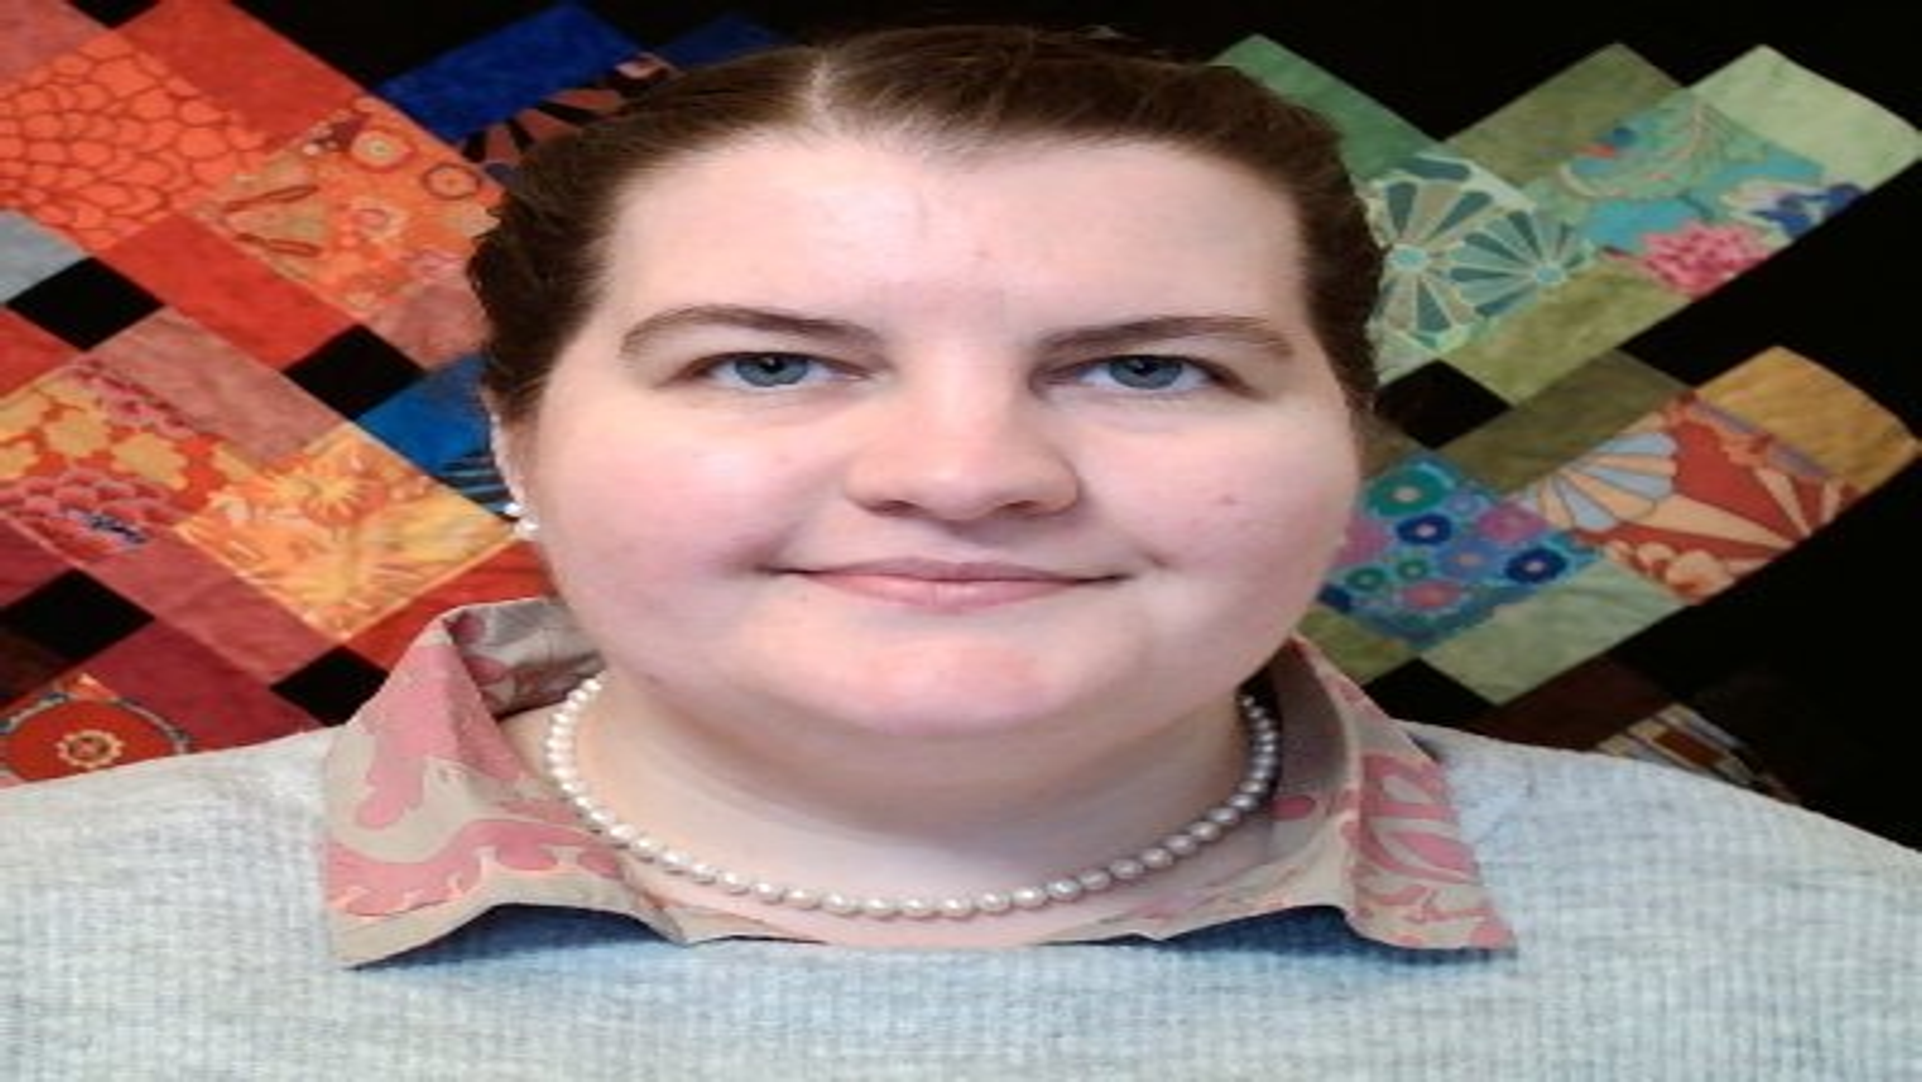

In [61]:
Image.fromarray(image_array_padded, 'RGB')

In [62]:
from pynq import Overlay
from pynq import allocate
#import pynq_sobel
import os
Kernel_Overlay = Overlay("general_filter_backup.bit")

In [63]:
Kernel_Overlay?

In [64]:
#Input array for DMA use
kernel_in_dma_array  = allocate(shape=(IMG_SIZE[1]+2, IMG_SIZE[0]+2, 4), dtype=np.uint8)

# Output array for DMA use
kernel_out_dma_array = allocate(shape=(IMG_SIZE[1],IMG_SIZE[0]), dtype=np.uint32)

The function 'do_conv' handles a number of tasks. Firstly, the 'write' method of the Overlay object is invoked to send the kernel weights and optionl normalisation values to the PL using AXI-4 lite. AXI-4 lite is an good, economic choice when modifying registers since this task is low throughput and does not demand high bandwidth utilisation. The weights to pass to the registers are extracted form the Kernel argument of the function. Next, this function copies the image data previously loaded into the DMA buffer and initiates the send and receive channels. Finally, the function waits until the DMA send and receipt of information is complete, before returning the filtered image array to the calling code.

In [65]:
def do_conv(image_array,Kernel = [0.1, 0, 0, 0, 1, 0, 0, 0, 1], div = 1):
    # Set overlay threshold
    
    Kernel_Overlay.general_filter_0.write(0x20, Kernel[0]) #W00 
    Kernel_Overlay.general_filter_0.write(0x1C, Kernel[1]) #W01 
    Kernel_Overlay.general_filter_0.write(0x18, Kernel[2]) #W02
    Kernel_Overlay.general_filter_0.write(0x14, Kernel[3]) #W10
    Kernel_Overlay.general_filter_0.write(0x10, Kernel[4]) #W11
    Kernel_Overlay.general_filter_0.write(0x0C, Kernel[5]) #W12
    Kernel_Overlay.general_filter_0.write(0x08, Kernel[6]) #W20
    Kernel_Overlay.general_filter_0.write(0x04, Kernel[7]) #W21
    Kernel_Overlay.general_filter_0.write(0x00, Kernel[8]) #W22
    Kernel_Overlay.general_filter_0.write(0x24,       div) #Matrix division
    # Copy image array into dma buffer
    kernel_in_dma_array[:, :, :3] = image_array[:, :, :]
    
    Kernel_Overlay.axi_dma.recvchannel.transfer(kernel_out_dma_array)
    Kernel_Overlay.axi_dma.sendchannel.transfer(kernel_in_dma_array)

    Kernel_Overlay.axi_dma.sendchannel.wait()
    Kernel_Overlay.axi_dma.recvchannel.wait()
    
    return kernel_out_dma_array

In [66]:
Kernel = dropdown.value[0:9]
div = dropdown.value[9]

In [67]:
%time image_output = do_conv(image_array_padded,Kernel,div)

CPU times: user 360 ms, sys: 30.8 ms, total: 391 ms
Wall time: 488 ms


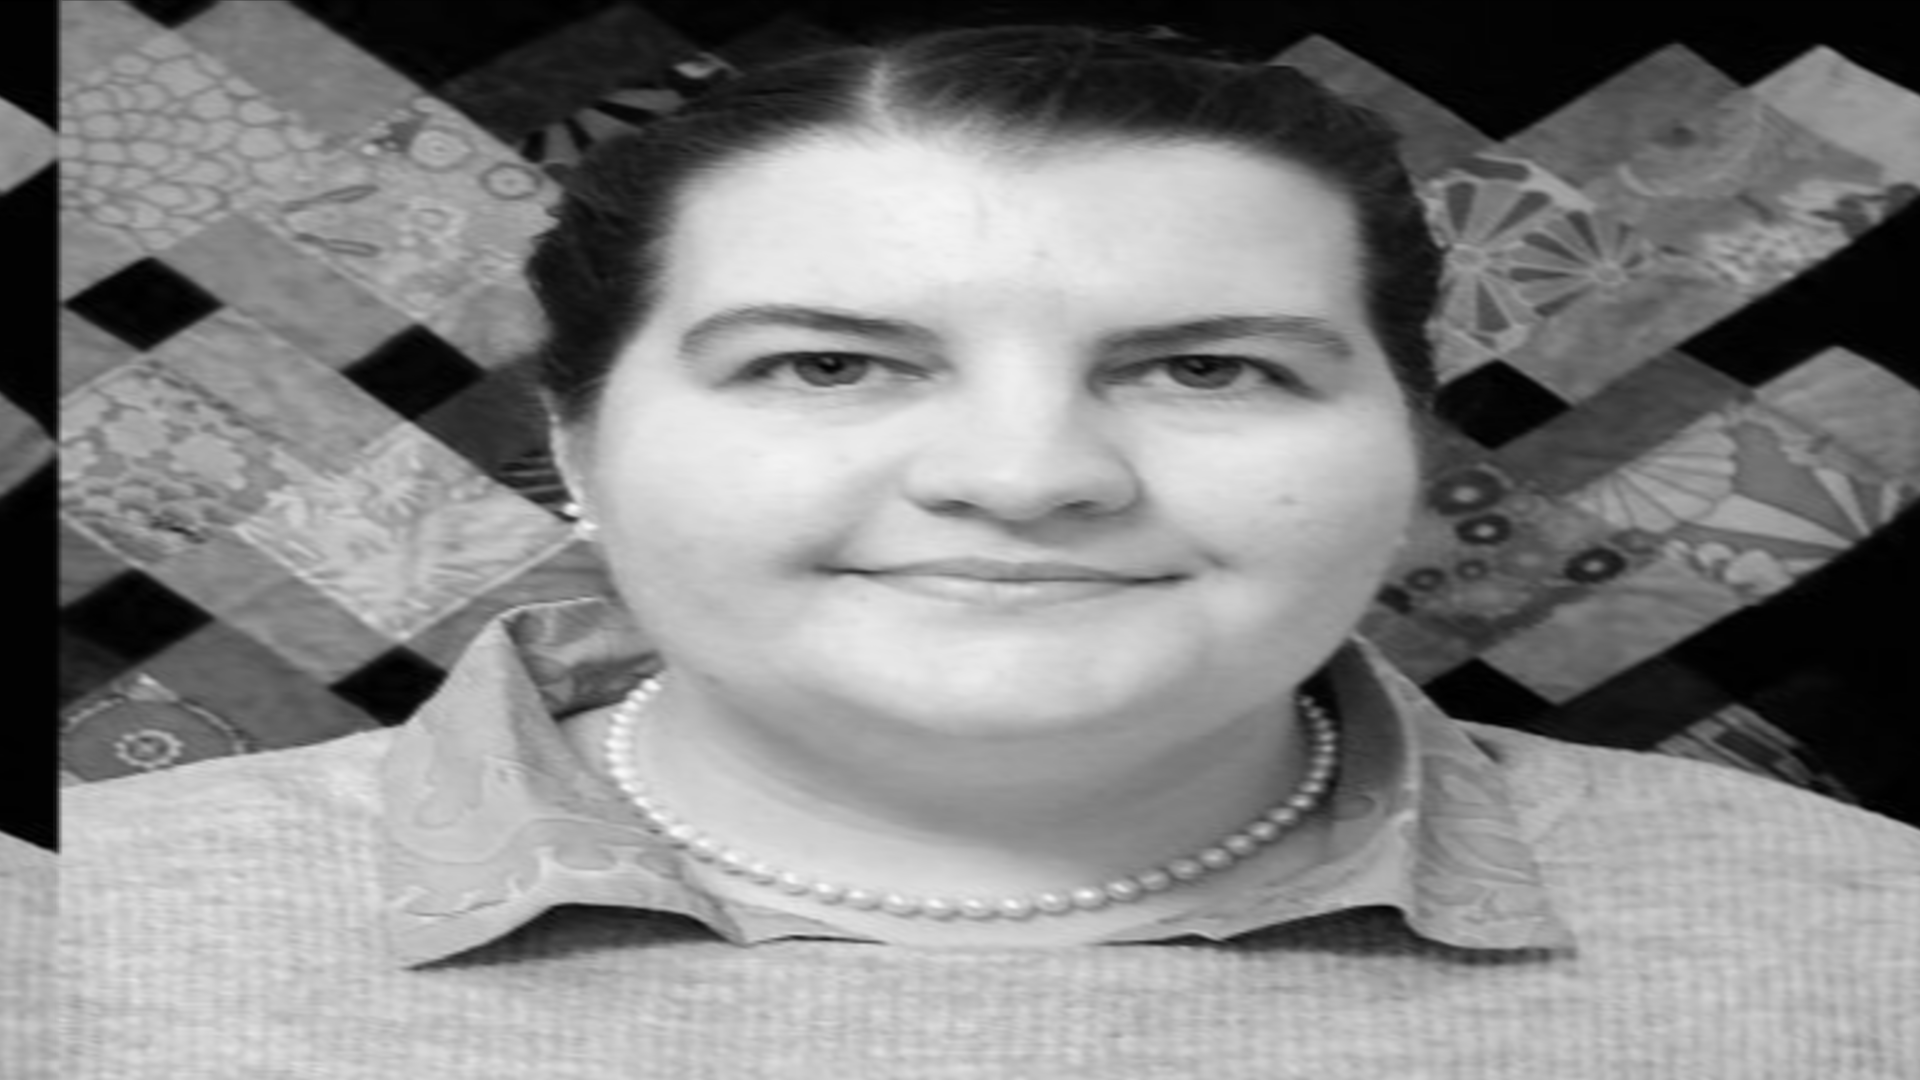

In [68]:
Image.fromarray(np.uint8(image_output), mode='P')

In [69]:
cvkernel = np.array([dropdown.value[0:2],
                     dropdown.value[3:5],
                     dropdown.value[6:8]])
cvkernel = np.divide(cvkernel,dropdown.value[9])

img_gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

In [70]:
%time comp =  cv2.filter2D(img_gray,-1, cvkernel)

CPU times: user 163 ms, sys: 19.5 ms, total: 183 ms
Wall time: 178 ms


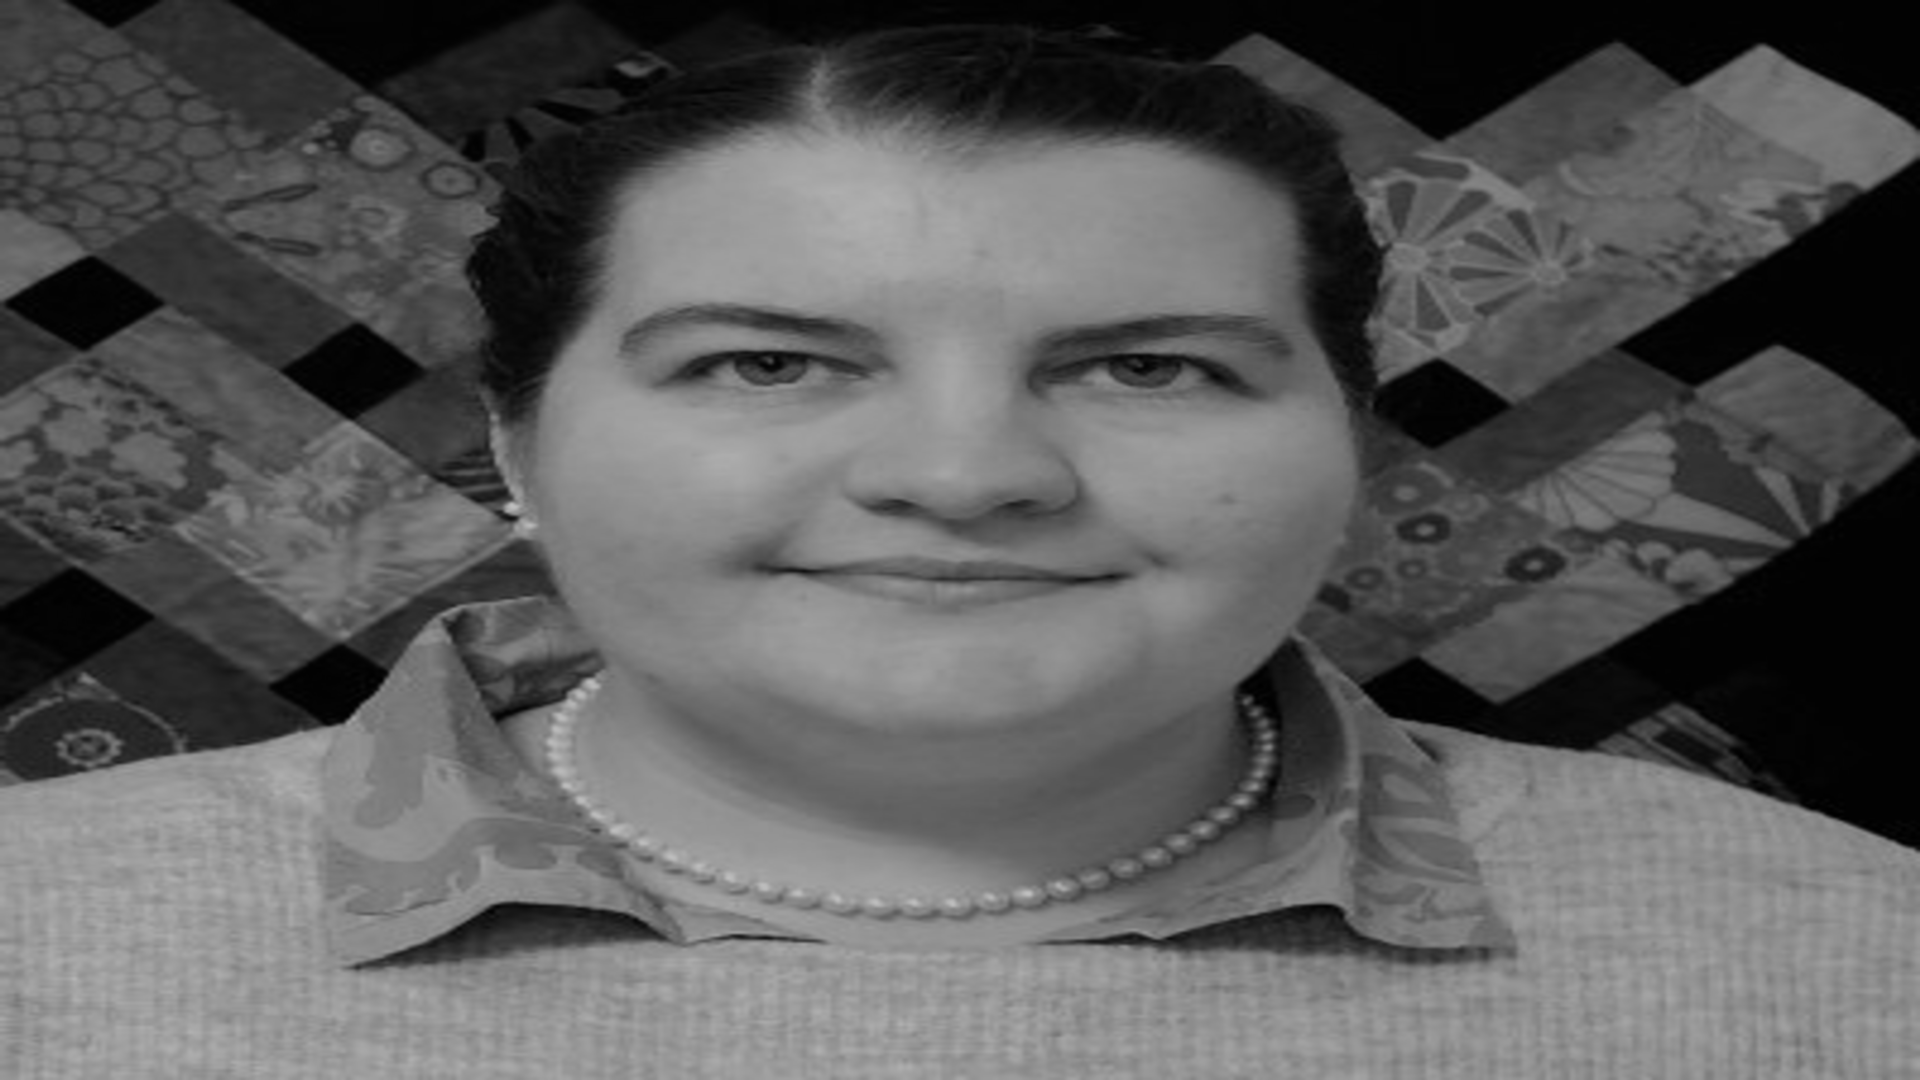

In [71]:
Image.fromarray(comp)